In [62]:
# Importing all of the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [63]:
# Loading the notebook cofigurations
import yaml
with open("../notebook_config.yaml", "rb") as f:
    config = yaml.safe_load(f)
    X_train_eng, X_val_eng, X_test_eng = config['paths']["X_train_eng"], config['paths']["X_val_eng"], config['paths']["X_test_eng"]
    y_train_eng, y_val_eng, y_test_eng = config['paths']["y_train_eng"], config['paths']["y_val_eng"], config['paths']["y_test_eng"]
    
    X_train_raw, X_val_raw, X_test_raw = config['paths']["X_train_raw"], config['paths']["X_val_raw"], config['paths']["X_test_raw"]
    y_train_raw, y_val_raw, y_test_raw = config['paths']["y_train_raw"], config['paths']["y_val_raw"], config['paths']["y_test_raw"]

    X_train, X_val, X_test = config['paths']["X_train"], config['paths']["X_val"], config['paths']["X_test"]
    y_train, y_val, y_test = config['paths']["y_train"], config['paths']["y_val"], config['paths']["y_test"]

In [64]:
# Load engineered features and labels
X_train_eng = pd.read_csv(X_train_eng)
X_val_eng = pd.read_csv(X_val_eng)
X_test_eng = pd.read_csv(X_test_eng)
y_train_eng = pd.read_csv(y_train_eng).squeeze()
y_val_eng = pd.read_csv(y_val_eng).squeeze()
y_test_eng = pd.read_csv(y_test_eng).squeeze()

# Load raw features and labels
X_train_raw = pd.read_csv(X_train_raw)
X_val_raw = pd.read_csv(X_val_raw)
X_test_raw = pd.read_csv(X_test_raw)
y_train_raw = pd.read_csv(y_train_raw).squeeze()
y_val_raw = pd.read_csv(y_val_raw).squeeze()
y_test_raw = pd.read_csv(y_test_raw).squeeze()

# Load the main split as well
X_train = pd.read_csv(X_train)
X_val = pd.read_csv(X_val)
X_test = pd.read_csv(X_test)
y_train = pd.read_csv(y_train).squeeze()
y_val = pd.read_csv(y_val).squeeze()
y_test = pd.read_csv(y_test).squeeze()

In [65]:
from sklearn.svm import SVC

svc_v1_model = SVC(
    C=0.80,
    kernel='rbf',
    gamma='scale',
    class_weight='balanced',
    probability=False,
    random_state=42
)

In [66]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(model, X_train, y_train, title, cv=5, scoring='accuracy'):
    train_sizes, train_scores, val_scores = learning_curve(
        model, X_train, y_train, cv=cv, scoring=scoring,
        train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1, random_state=42)
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    plt.figure(figsize=(8,6))
    plt.plot(train_sizes, train_mean, 'o-', color='blue', label=f'Training {scoring}')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
    plt.plot(train_sizes, val_mean, 'o-', color='green', label=f'Validation {scoring}')
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='green')

    plt.title(title)
    plt.xlabel('Training Set Size')
    plt.ylabel(f'{scoring}')
    plt.legend()
    plt.grid(True)
    plt.show()

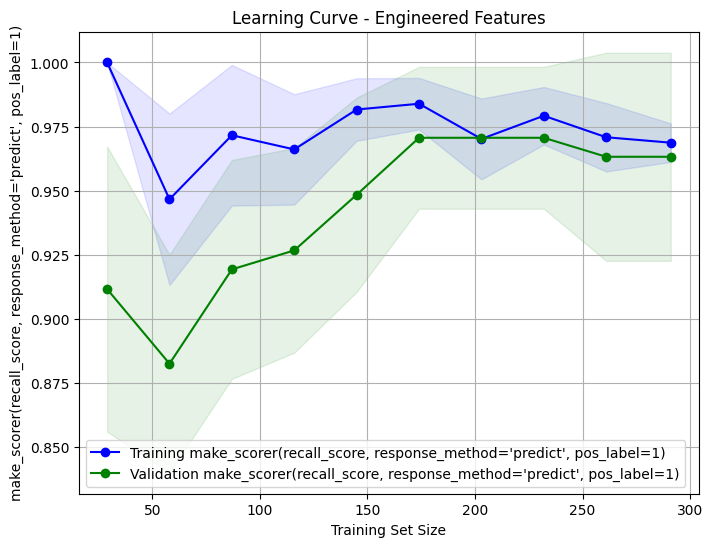

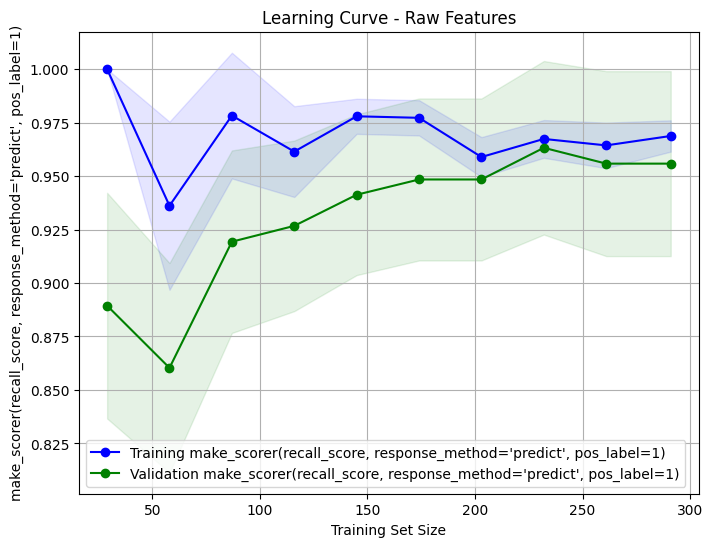

In [67]:
from sklearn.metrics import make_scorer, recall_score, precision_score, f1_score
from sklearn.model_selection import StratifiedKFold

recall_malignant = make_scorer(recall_score, pos_label=1)
precision_malignant = make_scorer(precision_score, pos_label=1)
f1_malignant = make_scorer(f1_score, pos_label=1)


stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
plot_learning_curve(
    svc_v1_model, X_train_eng, y_train_eng, 
    'Learning Curve - Engineered Features', 
    cv=stratified_cv, scoring=recall_malignant
)
# Plot on raw features
plot_learning_curve(
    svc_v1_model, X_train_raw, y_train_raw, 
    'Learning Curve - Raw Features', 
    cv=stratified_cv, scoring=recall_malignant
)

In [68]:
from sklearn.model_selection import cross_validate

scoring = {
    'recall_malignant': recall_malignant,
    'precision_malignant': precision_malignant,
    'f1_malignant': f1_malignant
}

cv_results_eng = cross_validate(
    svc_v1_model, X_train_eng, y_train_eng, 
    cv=stratified_cv, scoring=scoring, n_jobs=-1,
    return_train_score=False
)

cv_results_raw = cross_validate(
    svc_v1_model, X_train_raw, y_train_raw,
    cv=stratified_cv, scoring=scoring, n_jobs=-1,
    return_train_score=False
)
for metric in scoring.keys():
    scores = cv_results_eng[f'test_{metric}']
    print(f"Engineered Features - {metric}: {scores.mean():.3f} ± {scores.std():.3f}")
for metric in scoring.keys():
    scores = cv_results_raw[f'test_{metric}']
    print(f"Raw Features - {metric}: {scores.mean():.3f} ± {scores.std():.3f}")

Engineered Features - recall_malignant: 0.963 ± 0.041
Engineered Features - precision_malignant: 0.970 ± 0.029
Engineered Features - f1_malignant: 0.966 ± 0.033
Raw Features - recall_malignant: 0.956 ± 0.043
Raw Features - precision_malignant: 0.950 ± 0.029
Raw Features - f1_malignant: 0.952 ± 0.026


In [69]:
from sklearn.model_selection import RandomizedSearchCV

recall_benign = make_scorer(recall_score, pos_label=1)

scoring = {
    'recall_malignant': recall_malignant,
    'recall_benign': recall_benign
}

param_dist = {
    "C": [0.01, 0.1, 1, 10, 50, 100, 500],
    "kernel": ['linear', 'poly', 'rbf', 'sigmoid'],
    "degree": [2, 3, 4, 5],
    "gamma": ['scale', 'auto', 0.001, 0.01, 0.1, 1, 10],
    'class_weight': ['balanced', None],  
    'shrinking': [True, False],
    'tol': [1e-4, 1e-3, 1e-2],
    'probability': [False],
}

svc = SVC(random_state=42)

random_search_eng = RandomizedSearchCV(
    estimator=svc, 
    param_distributions=param_dist, 
    n_iter=50,
    scoring=scoring,
    refit='recall_malignant',
    cv=stratified_cv,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

random_search_eng.fit(X_train_eng, y_train_eng)
print("Best Parameters (Engineered):", random_search_eng.best_params_)

random_search_raw = RandomizedSearchCV(
    estimator=svc, 
    param_distributions=param_dist, 
    n_iter=50,
    scoring=scoring,
    refit='recall_malignant',
    cv=stratified_cv,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

random_search_raw.fit(X_train_raw, y_train_raw)
print("Best Parameters (Raw):", random_search_raw.best_params_)

best_svc_eng = random_search_eng.best_estimator_
best_svc_raw = random_search_raw.best_estimator_

results_eng = random_search_eng.cv_results_
results_raw = random_search_raw.cv_results_

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters (Engineered): {'tol': 0.0001, 'shrinking': True, 'probability': False, 'kernel': 'sigmoid', 'gamma': 0.01, 'degree': 3, 'class_weight': 'balanced', 'C': 500}
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters (Raw): {'tol': 0.01, 'shrinking': False, 'probability': False, 'kernel': 'linear', 'gamma': 10, 'degree': 3, 'class_weight': 'balanced', 'C': 1}


In [70]:
# Classification report on the Validation Splits
from sklearn.metrics import classification_report

# Predict on validation set with best estimator from engineered feature pool
y_val_pred_eng = best_svc_eng.predict(X_val_eng)
print("Classification Report - Engineered Features Validation Set")
print(classification_report(y_val_eng, y_val_pred_eng, target_names=['Benign', 'Malignant']))

# Predict on test set with best estimator from engineered feature pool
y_test_pred_eng = best_svc_eng.predict(X_test_eng)
print("Classification Report - Engineered Features Test Set")
print(classification_report(y_test_eng, y_test_pred_eng, target_names=['Benign', 'Malignant']))

Classification Report - Engineered Features Validation Set
              precision    recall  f1-score   support

      Benign       0.95      0.91      0.93        57
   Malignant       0.86      0.91      0.89        34

    accuracy                           0.91        91
   macro avg       0.90      0.91      0.91        91
weighted avg       0.91      0.91      0.91        91

Classification Report - Engineered Features Test Set
              precision    recall  f1-score   support

      Benign       0.99      0.94      0.96        72
   Malignant       0.91      0.98      0.94        42

    accuracy                           0.96       114
   macro avg       0.95      0.96      0.95       114
weighted avg       0.96      0.96      0.96       114



In [71]:
# Predict on validation set with best estimator from raw feature pool
y_val_pred_raw = best_svc_raw.predict(X_val_raw)
print("Classification Report - Raw Features Validation Set")
print(classification_report(y_val_raw, y_val_pred_raw, target_names=['Benign', 'Malignant']))

# Predict on test set with best estimator from raw feature pool
y_test_pred_raw = best_svc_raw.predict(X_test_raw)
print("Classification Report - Raw Features Test Set")
print(classification_report(y_test_raw, y_test_pred_raw, target_names=['Benign', 'Malignant']))

Classification Report - Raw Features Validation Set
              precision    recall  f1-score   support

      Benign       0.96      0.96      0.96        57
   Malignant       0.94      0.94      0.94        34

    accuracy                           0.96        91
   macro avg       0.95      0.95      0.95        91
weighted avg       0.96      0.96      0.96        91

Classification Report - Raw Features Test Set
              precision    recall  f1-score   support

      Benign       0.99      0.97      0.98        72
   Malignant       0.95      0.98      0.96        42

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



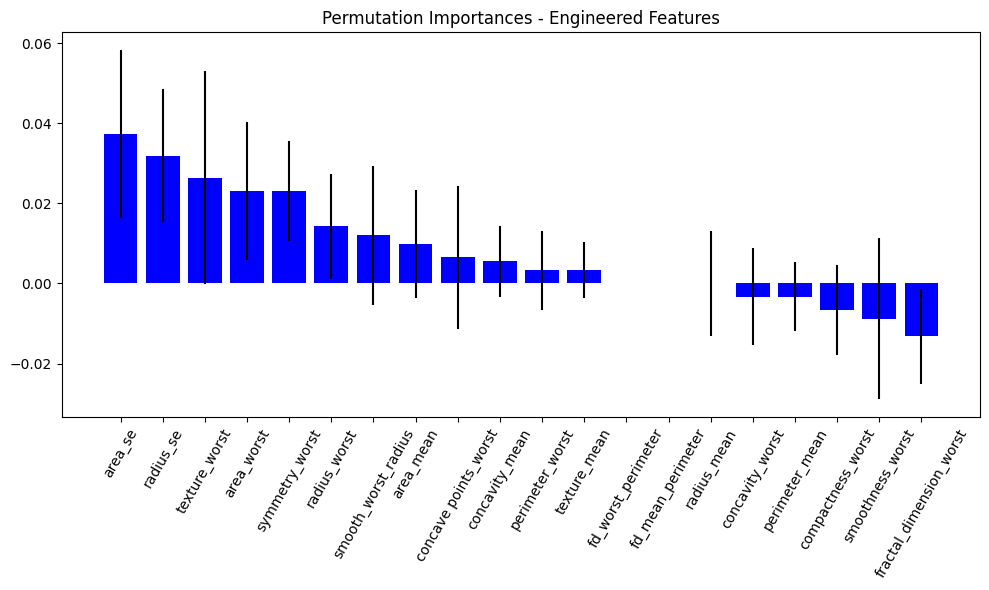

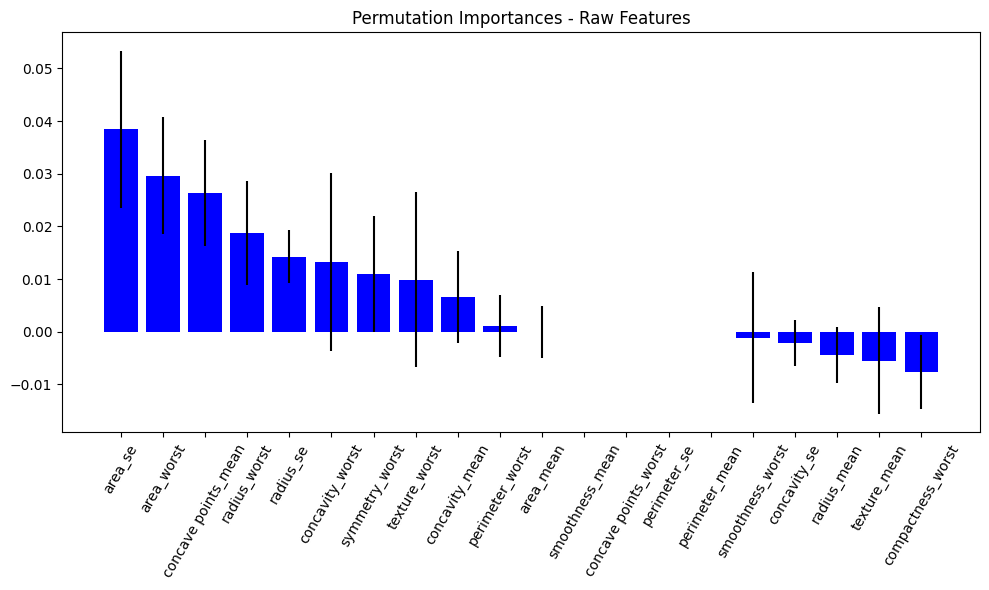

In [72]:
from sklearn.inspection import permutation_importance

def plot_permutation_importances(importances_result, feature_names, title):
    importances = importances_result.importances_mean
    stds = importances_result.importances_std
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(10,6))
    plt.title(title)
    plt.bar(range(len(importances)), importances[indices], color='b', yerr=stds[indices], align='center')
    plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=60)
    plt.tight_layout()
    plt.show()

perm_importance_eng = permutation_importance(
    best_svc_eng, X_val_eng, y_val_eng,
    scoring='accuracy',
    # scoring=make_scorer(recall_score, pos_label=1),
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)
perm_importance_raw = permutation_importance(
    best_svc_raw, X_val_raw, y_val_raw,
    # scoring=make_scorer(recall_score, pos_label=1),
    scoring='accuracy',
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

# Plot importances for engineered features
plot_permutation_importances(perm_importance_eng, X_val_eng.columns, "Permutation Importances - Engineered Features")

# Plot importances for raw features
plot_permutation_importances(perm_importance_raw, X_val_raw.columns, "Permutation Importances - Raw Features")

In [73]:
def select_features_above_threshold_perm(perm_result, feature_names, threshold):
    importances = perm_result.importances_mean
    selected = [(feature, imp) for feature, imp in zip(feature_names, importances) if imp >= threshold]
    # Sort by importance descending
    selected_sorted = sorted(selected, key=lambda x: x[1], reverse=True)
    return selected_sorted

selected_eng = select_features_above_threshold_perm(perm_importance_eng, X_val_eng.columns, threshold=0.01)
print("Selected Engineered Features:", [f[0] for f in selected_eng])


selected_raw = select_features_above_threshold_perm(perm_importance_raw, X_val_raw.columns, threshold=0.01)
print("Selected Raw Features:", [f[0] for f in selected_raw])

combined_dict = {}

for feature, importance in selected_eng + selected_raw:
    if feature in combined_dict:
        combined_dict[feature] = max(combined_dict[feature], importance)
    else:
        combined_dict[feature] = importance

combined_sorted = sorted(combined_dict.items(), key=lambda x: x[1], reverse=True)
combined_features = [f[0] for f in combined_sorted]

print("Combined Unique Features:", len(combined_features))
print("Combined Features List:", combined_features)

Selected Engineered Features: ['area_se', 'radius_se', 'texture_worst', 'area_worst', 'symmetry_worst', 'radius_worst', 'smooth_worst_radius']
Selected Raw Features: ['area_se', 'area_worst', 'concave points_mean', 'radius_worst', 'radius_se', 'concavity_worst', 'symmetry_worst']
Combined Unique Features: 9
Combined Features List: ['area_se', 'radius_se', 'area_worst', 'concave points_mean', 'texture_worst', 'symmetry_worst', 'radius_worst', 'concavity_worst', 'smooth_worst_radius']


In [74]:
X_train_combined = X_train[combined_features]
X_val_combined = X_val[combined_features]
X_test_combined = X_test[combined_features]
y_train_combined = y_train
y_val_combined = y_val
y_test_combined = y_test

In [75]:
param_dist = {
    "C": [0.01, 0.1, 1, 10, 50, 100, 500],
    "kernel": ['linear', 'poly', 'rbf', 'sigmoid'],
    "degree": [2, 3, 4, 5],
    "gamma": ['scale', 'auto', 0.001, 0.01, 0.1, 1, 10],
    'class_weight': ['balanced', None],  
    'shrinking': [True, False],
    'tol': [1e-4, 1e-3, 1e-2],
    'probability': [False],
}

svc_combined = SVC(random_state=42)

random_search_combined = RandomizedSearchCV(
    estimator=svc_combined, 
    param_distributions=param_dist, 
    n_iter=50,
    scoring=scoring,
    refit='recall_malignant',
    cv=stratified_cv,
    n_jobs=-1,
    verbose=2,
    random_state=42
)
random_search_combined.fit(X_train_combined, y_train_combined)

print("Best Hyperparameters:", random_search_combined.best_params_)
best_svc_combined = random_search_combined.best_estimator_

y_val_pred = best_svc_combined.predict(X_val_combined)
print("Validation Classification Report:\n", classification_report(y_val_combined, y_val_pred, target_names=['Benign', 'Malignant']))

y_test_pred = best_svc_combined.predict(X_test_combined)
print("Test Classification Report:\n", classification_report(y_test_combined, y_test_pred, target_names=['Benign', 'Malignant']))


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Hyperparameters: {'tol': 0.0001, 'shrinking': True, 'probability': False, 'kernel': 'sigmoid', 'gamma': 0.01, 'degree': 3, 'class_weight': 'balanced', 'C': 500}
Validation Classification Report:
               precision    recall  f1-score   support

      Benign       0.96      0.96      0.96        57
   Malignant       0.94      0.94      0.94        34

    accuracy                           0.96        91
   macro avg       0.95      0.95      0.95        91
weighted avg       0.96      0.96      0.96        91

Test Classification Report:
               precision    recall  f1-score   support

      Benign       0.99      0.97      0.98        72
   Malignant       0.95      0.98      0.96        42

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114

